## Use Case 3

Has received a Ministerial request and needs a summary of industry activity for an area of
interest. Needs to understand what industry activity /coverage there is for a certain area, stats
and overlaps with DOC and iwi land interests.

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Fetching Taranaki land district boundary from LINZ catalogue

In [23]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS',
    version="2.0.0",
    request='GetFeature',
    typeName='data.linz.govt.nz:layer-50785',
    outputFormat='json',
    srsname='urn:ogc:def:crs:EPSG::4326'
)

q = Request('GET', 'https://data.linz.govt.nz/services;key=e1cd2f7203d74a9ea5d179f269de890b/wfs', params=params).prepare().url

tranaki_district_df = gpd.read_file(q)

tranaki_district_df = tranaki_district_df[tranaki_district_df.name == 'Taranaki']

tranaki_district_df.bounds

,minx,miny,maxx,maxy
4,173.495896,-39.940141,175.426704,-38.406606


In [24]:
from ipywidgets import Text, HTML, Layout
import textwrap
from ipyleaflet import Map, GeoData, basemaps, LayersControl, WidgetControl

tranaki_district_geo_data = GeoData(
    geo_dataframe=tranaki_district_df,
    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Taranaki District'
)
m = Map(center=(-39.285543, 174.025330), zoom=7)
m.add_layer(tranaki_district_geo_data)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Fetching conservation layer from LINZ catalogue

In [25]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS',
    version="2.0.0",
    request='GetFeature',
    typeName='data.linz.govt.nz:layer-53564',
    outputFormat='json',
    srsname='urn:ogc:def:crs:EPSG::4326',
    bbox='173.495896,-39.940141,175.426704,-38.406606,EPSG:4326'
)
q = Request('GET', 'https://data.linz.govt.nz/services;key=e1cd2f7203d74a9ea5d179f269de890b/wfs', params=params).prepare().url

conservation_layer_df = gpd.read_file(q)

conservation_layer_df.head()

,id,napalis_id,start_date,name,recorded_area,overlays,type,legislation,section,reserve_purpose,ctrl_mg_vst,geometry
0,layer-53564.2991035,2991035,None,Mangapouri Cemetery - Local Purpose (Cemetery)...,20.4325,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Cemetery,New Plymouth District Council,(POLYGON ((174.1296076505625 -39.1350512713130...
1,layer-53564.2797902,2797902,1998-01-01T12:00:00,Esplanade - Mokau Coast,0.4320,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Esplanade,Waitomo District Council,(POLYGON ((174.6169666168091 -38.6940508875841...
2,layer-53564.2797905,2797905,1961-01-01T12:00:00,Esplanade - Mokau River,0.0511,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Esplanade,Waitomo District Council,(POLYGON ((174.6258703165376 -38.6985954379401...
3,layer-53564.2797951,2797951,1919-01-01T12:00:00,Quarry - Pura Stream,10.2790,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,Quarry,Ruapehu District Council,(POLYGON ((174.9565230327718 -38.7284041711950...
4,layer-53564.2797952,2797952,1972-01-01T00:00:00,St John Ambulance Station - Mokau,0.1012,No,Reserve,Reserves Act 1977,s.23 - Local Purpose Reserve,St Johns Ambulance Station,Commandry in NZ Order of St. John Trust Board,(POLYGON ((174.6195297670146 -38.6978789878483...


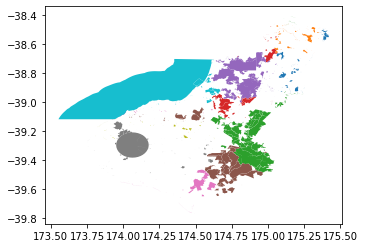

In [26]:
taranaki_protected_areas = gpd.overlay(tranaki_district_df, conservation_layer_df, how='intersection')

taranaki_protected_areas.plot(cmap='tab10')

### Plotting identified conservation layer in Taranaki region

In [27]:
def taranaki_result_click_handler (feature=None, **kwargs):
    if feature is not None:        
        taranaki_protected_areas_html.value = ''
        items = feature['properties']
        for item in items:
            taranaki_protected_areas_html.value += '''
                <h6>{}: <b>{}</b></h6>'''.format(item, textwrap.shorten(str(items[item]), width=40))

taranaki_protected_areas_geo_data = GeoData(
    geo_dataframe=taranaki_protected_areas,
    style={'color': 'red', 'fillColor': '#cc3333', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'green' , 'fillOpacity': 0.2},
    name='Taranaki Conservation Area'
)
taranaki_protected_areas_geo_data.on_click(taranaki_result_click_handler)

m = Map(center=(-39.285543, 174.025330), zoom=9, layout=dict(height='600px'))
m.add_layer(taranaki_protected_areas_geo_data)

taranaki_protected_areas_html = HTML('')
taranaki_protected_areas_html.layout.margin = '0px 10px 10px 10px'
taranaki_protected_areas_html_control = WidgetControl(widget=taranaki_protected_areas_html, position='bottomright')
m.add_control(taranaki_protected_areas_html_control)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Searching Geonetwork catalogue to identify active permit layers

In [28]:
from owslib.csw import CatalogueServiceWeb
from owslib.fes import PropertyIsEqualTo, PropertyIsLike, BBox
import pandas as pd
from ipyaggrid import Grid

csw = CatalogueServiceWeb('http://explorer-portal.australiaeast.cloudapp.azure.com/geonetwork/srv/eng/csw')

permit_query = PropertyIsLike('csw:AnyText', '%Active%Permits%')
csw.getrecords2(constraints=[permit_query], maxrecords=200)

data = {}
attribs = ['identifier', 'title', 'abstract', 'type', 'subjects' ]
for key in csw.records:
    record = csw.records[key]
    for attrib in attribs:
        if attrib not in data.keys():
            data[attrib] = []
        data[attrib].append(getattr(record, attrib))

df_record = pd.DataFrame(data)

record_column_defs = [{'field': c, 'width': 300, 'editable': True} for c in df_record.columns]

record_grid_options = {
    'columnDefs' : record_column_defs,
    'enableFilter':'true',
    'enableSorting':'true'
}

g_record = Grid(
    grid_data=df_record,
    grid_options=record_grid_options,
    theme='ag-theme-balham',
    columns_fit='',
    quick_filter=True,
    export_csv=True,
    export_excel=True
)

g_record

Grid(compress_data=True, export_mode='disabled', height='350px', menu={'buttons': [{'name': 'Export to CSV', '…

### Fetching catalogue records to identify service to be used

In [29]:
from owslib.csw import CatalogueServiceWeb

csw.getrecordbyid(id=['aecdf0b2b48a07a8f95888d245781b9dc2a3faec', 'b194c58124d86f7cab8a1890e8e51971ec6443d9'])

record = csw.records['aecdf0b2b48a07a8f95888d245781b9dc2a3faec']
petro_permit_layer = record.uris[0]

petro_permit_layer

{'protocol': 'OGC:WFS-1.1.0-http-get-feature',
 'name': 'Permits_Petroleum:Petroleum_Active_Permits',
 'description': 'Petroleum_Active_Permits',
 'url': 'https://data.nzpam.govt.nz/hosting/services/Permits/Petroleum/MapServer/WFSServer?'}

In [30]:
record = csw.records['b194c58124d86f7cab8a1890e8e51971ec6443d9']
mineral_permit_layer = record.uris[0]

mineral_permit_layer

{'protocol': 'OGC:WFS-1.1.0-http-get-feature',
 'name': 'Permits_Minerals:Mineral_Active_Permits',
 'description': 'Mineral_Active_Permits',
 'url': 'https://data.nzpam.govt.nz/hosting/services/Permits/Minerals/MapServer/WFSServer?'}

### Fetching active petroleum permits

In [31]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS',
    version="2.0.0",
    request='GetFeature',
    typeName=petro_permit_layer['name'],
    outputFormat='geojson',
    srsname='urn:ogc:def:crs:EPSG::4326'
)
q = Request('GET', petro_permit_layer['url'], params=params).prepare().url

petroleum_df = gpd.read_file(q)

petroleum_df.head()

,OBJECTID,Permit_Number,PERMIT_NONEXCLUSIVE_YN,PERMIT_DURATION_YEARS,PERMIT_DURATION_MONTHS,PERMIT_AREA,PERMIT_AREA_UNITS,PERMIT_OFFSHORE_ONSHORE,Status,PERMIT_STATUS_DATE,...,Owner_s_,Share_Percentage_s_,Operator,Mineral_s_,B1_PER_ID1,B1_PER_ID2,B1_PER_ID3,SHAPE.STArea__,SHAPE.STLength__,geometry
0,1599,51378,N,15,0,68.120,SQKM,Onshore,Active - Change Pending,2/12/2009,...,"Greymouth Gas Kaimiro Limited, Greymouth Gas P...","24.08, 20, 20, 20, 15.92",Greymouth Petroleum Mining Group Limited,"Condensate, Gas, LPG, Oil, Petroleum",08ATX,00000,00144,6.814331e+07,35244.802130,"POLYGON ((174.21214389113 -38.98902043211932, ..."
1,1601,38086,N,42,0,27.420,SQKM,Onshore,Active,11/11/1983,...,Todd Energy Limited,100,Todd Energy Limited,"Condensate, Gas, LPG, Oil, Petroleum",94ATX,00000,00002,2.740828e+07,31228.449124,POLYGON ((174.3057574186126 -39.13851877895122...
2,1616,38146,N,39,4,256.517,SQKM,Offshore,Active - Change Pending,24/01/2018,...,"Beach Energy Resources NZ (Kupe) Limited, Kupe...","32.1875, 17.8125, 46, 4",Beach Energy Resources NZ (Kupe) Limited,"Condensate, Gas, LPG, Oil, Petroleum",92ATX,00000,00001,2.565727e+08,92239.357285,POLYGON ((174.1918720786393 -39.64824840659794...
3,1634,52278,N,40,0,10.536,SQKM,Onshore,Active - Change Pending,16/12/2010,...,GSNZ SPV1 LIMITED,100,GSNZ SPV1 LIMITED,"Condensate, Gas, LPG, Oil, Petroleum",09ATX,00000,00128,1.053403e+07,15652.293945,POLYGON ((174.3416666680532 -39.25138887973409...
4,1645,38151,N,30,0,18.420,SQKM,Onshore,Active - Change Pending,30/01/2002,...,Westside New Zealand Limited,100,Westside New Zealand Limited,"Condensate, Gas, LPG, Oil, Petroleum",01ATX,00000,00004,1.842724e+07,21588.669602,POLYGON ((174.3482626113051 -39.64408150013347...


### Fetching active mineral permits

In [32]:
import geopandas as gpd
from requests import Request
from owslib.wfs import WebFeatureService

params = dict(
    service='WFS', 
    version="2.0.0", 
    request='GetFeature', 
    typeName=mineral_permit_layer['name'], 
    outputFormat='geojson', 
    srsname='urn:ogc:def:crs:EPSG::4326'
)
q = Request('GET', mineral_permit_layer['url'], params=params).prepare().url

minerals_df = gpd.read_file(q)

minerals_df.loc[minerals_df.PERMIT_NUMBER == '41511']

,OBJECTID,PERMIT_NUMBER,PERMIT_NONEXCLUSIVE_YN,PERMIT_DURATION_YEARS,PERMIT_DURATION_MONTHS,PERMIT_AREA,PERMIT_AREA_UNITS,PERMIT_OFFSHORE_ONSHORE,PERMIT_STATUS,PERMIT_STATUS_DATE,...,OWNERS,SHARE_PERCENTAGE,OPERATOR,MINERALS,B1_PER_ID1,B1_PER_ID2,B1_PER_ID3,SHAPE.STArea__,SHAPE.STLength__,geometry
173,8901,41511,N,40,0,310.626,Ha,Onshore,Active,14/03/2000,...,King Country Mining Limited,100,King Country Mining Limited,Coal,97ATX,00000,00071,3.107581e+06,7099.044173,"POLYGON ((174.9140117043336 -38.913188707575, ..."


### Overlay Active Permits to do intersection on Taranaki protected areas

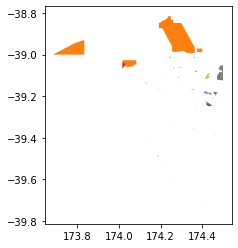

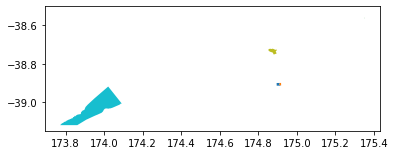

In [33]:
res_petro_intersection = gpd.overlay(petroleum_df, taranaki_protected_areas, how='intersection')
res_minerals_intersection = gpd.overlay(minerals_df, taranaki_protected_areas, how='intersection')

petro_ax = res_petro_intersection.plot(cmap='tab10')
minerals_ax = res_minerals_intersection.plot(cmap='tab10')

display(petro_ax, minerals_ax)

In [34]:
def result_click_handler (feature=None, **kwargs):
    if feature is not None:        
        result_html.value = ''
        items = feature['properties']
        for item in items:
            result_html.value += '''
                <h6>{}: <b>{}</b></h6>'''.format(item, textwrap.shorten(str(items[item]), width=40))

petro_taranaki_geo_data = GeoData(
    geo_dataframe=res_petro_intersection,
    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name='Petroleum Overlapping Area'
)
petro_taranaki_geo_data.on_click(result_click_handler)

minerals_taranaki_geo_data = GeoData(
    geo_dataframe=res_minerals_intersection,
    style={'color': 'red', 'fillColor': '#cc3333', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'green' , 'fillOpacity': 0.2},
    name='Minerals Overlapping Area'
)
minerals_taranaki_geo_data.on_click(result_click_handler)


m = Map(center=(-39.285543, 174.025330), zoom=9, layout=dict(height='800px'))
m.add_layer(petro_taranaki_geo_data)
m.add_layer(minerals_taranaki_geo_data)
m.add_layer(LayersControl())

result_html = HTML('')
result_html.layout.margin = '0px 10px 10px 10px'
result_control = WidgetControl(widget=result_html, position='bottomright')
m.add_control(result_control)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Computing Overlap %, Overlap area in sq km, Number of permits and Permit Type

In [37]:
from ipywidgets import HTML

petro_area_sq_km = res_petro_intersection.to_crs({'init': 'EPSG:3857'}).area.sum() / 10**6
minerals_area_sq_km = res_minerals_intersection.to_crs({'init': 'EPSG:3857'}).area.sum() / 10**6
taranaki_protected_areas_sq_km = taranaki_protected_areas.to_crs({'init': 'EPSG:3857'}).area.sum() / 10**6

petro_overlap_percentage = (petro_area_sq_km / taranaki_protected_areas_sq_km) * 100
minerals_overlap_percentage = (minerals_area_sq_km / taranaki_protected_areas_sq_km) * 100

no_of_petro_permits = len(res_petro_intersection['Permit_Number'].unique())
no_of_minerals_permits = len(res_minerals_intersection['PERMIT_NUMBER'].unique())

petro_permittype_df = res_petro_intersection.drop_duplicates('Permit_Number', keep='last').groupby(['Type'], sort=False).size().reset_index(name='Count')
minerals_permittype_df = res_minerals_intersection.drop_duplicates('PERMIT_NUMBER', keep='last').groupby(['PERMIT_TYPE_DESCRIPTION'], sort=False).size().reset_index(name='Count')

data = [
    ['Petroleum Permits', petro_overlap_percentage, petro_area_sq_km, no_of_petro_permits], 
    ['Minerals Permits', minerals_overlap_percentage, minerals_area_sq_km, no_of_minerals_permits]
]
output_df = pd.DataFrame(data, columns = ['Permit Type', 'Overlap % with Protected Areas', 'Overlap area in Sq Km', 'Number of Permits in Overlap Area'])

display (output_df.head(), petro_permittype_df, minerals_permittype_df)

,Permit Type,Overlap % with Protected Areas,Overlap area in Sq Km,Number of Permits in Overlap Area
0,Petroleum Permits,5.992007,435.620445,19
1,Minerals Permits,4.621388,335.976122,6


,Type,Count
0,Petroleum Mining Permit,8
1,Petroleum Exploration Permit,8
2,Petroleum Mining Licence,3


,PERMIT_TYPE_DESCRIPTION,Count
0,Minerals Mining Permit,4
1,Coal Mining Licence,1
2,Minerals Exploration Permit,1
